# Example usage for clustering in "movekit"

In [1]:
import movekit as mkit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d, convex_hull_plot_2d, delaunay_plot_2d

/home/luke/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


### Read in CSV file and preprocess

In [2]:
# Enter path to CSV file
path = "./datasets/fish-5.csv"

In [3]:
# Read in CSV file and preprocess
data = mkit.read_data(path)
preprocessed_data = mkit.preprocess(data)

Total number of missing values =  0
y            0
x            0
animal_id    0
time         0
dtype: int64


In [4]:
# converting positional data into scale, defined by user
mkit.convert_measueres(preprocessed_data, x_min = 0, x_max = 100, y_min = 0, y_max = 100).head()

,time,animal_id,x,y
0,1,312,49.663862,84.937627
1,1,511,44.688738,87.375033
2,1,607,47.555424,82.312218
3,1,811,55.281665,83.650358
4,1,905,44.134850,92.457755


### Detecting outliers
Function performs detection of outliers, based on user's criteria, regarding features, method and share of outliers.

In [5]:
# Extracting features for later use
feats = mkit.extract_features(preprocessed_data, fps = 3)

In [6]:
mkit.get_convex_hulls_areas(preprocessed_data, group_output=True).head(10)

AttributeError: module 'movekit' has no attribute 'get_convex_hulls_areas'

In [7]:
outs = mkit.outlier_detection(feats)

# printing all rows where outliers are present
outs[outs.loc[:,"outlier"] == 1]

,time,animal_id,outlier,x,y,distance,average_speed,average_acceleration,direction,stopped
1876,877,511,1,64.024072,7.887287,0.645740,0.645586,0.012156,-1.570202,0
1989,990,511,1,84.668724,35.864372,0.989962,0.974461,-0.011696,85.181662,0
1990,991,511,1,84.777247,36.784482,0.926487,0.934912,-0.039548,83.273314,0
1991,992,511,1,84.925232,37.660356,0.888287,0.895494,-0.039419,80.410027,0


In [8]:
# same function, different parameters
other_outs = mkit.outlier_detection(dataset = feats, features = ["average_speed", "average_acceleration"], contamination = 0.05, n_neighbors = 8, method = "median", metric = "euclidean")

# printing all rows where outliers are present
other_outs[other_outs.loc[:,"outlier"] == 1].head()

,time,animal_id,outlier,x,y,distance,average_speed,average_acceleration,direction,stopped
697,698,312,1,14.463095,47.140140,0.724021,0.722229,0.043150,-71.265096,0
698,699,312,1,14.718194,46.414669,0.769015,0.773842,0.051613,-70.626723,0
699,700,312,1,15.001480,45.636114,0.828491,0.819444,0.045602,-70.005491,0
700,701,312,1,15.300269,44.828807,0.860826,0.849685,0.030241,-69.690192,0
701,702,312,1,15.601877,44.023711,0.859737,0.850136,0.000452,-69.462855,0


### Group-level Analysis

Below we perform Analysis on Group-Level. This consists of:
- Group-Level averages,
- Centroid Medoid computation
- A dynamic time warping matrix, 
- A clustering over time based on absolute features,
- The centroid direction,
- The heading difference of each animal with respect to the current centroid
- The group - polarization for each timestep. 

#### Obtain group-level records for each point in time
Records consist of total group-distance, mean-speed mean-acceleration and mean distance from centroid. If input doesn't contain centroid or feature data, it is calculated, showing a warning.
Parameter object_output produces a post gis - compatible point.

In [9]:
mkit.group_movement(data).head()

/home/luke/.local/lib/python3.8/site-packages/movekit/feature_extraction.py:260: UserWarning: Recalculating features, since distance, speed or acceleration not found in input.
  warnings.warn('Recalculating features, since distance, speed or acceleration not found in input.')
/home/luke/.local/lib/python3.8/site-packages/movekit/feature_extraction.py:265: UserWarning: Recalculating centroid-distances, since not found in input dataset!
  warnings.warn('Recalculating centroid-distances, since not found in input dataset!')


,total_dist,mean_speed,mean_acceleration,mean_distance_centroid
time,,,,
1,0.000000,0.029985,0.000098,4.9040
2,0.219746,0.030084,0.000098,4.9232
3,0.194570,0.029956,0.000098,4.9394
4,0.174818,0.029825,0.000098,4.9516
5,0.160492,0.030167,0.000098,4.9614


#### Obtain centroid, medoid and distance to centroid 
Parameter options go either for each unit per timestamp or as post-gis compatible object

In [10]:
movement = mkit.centroid_medoid_computation(data, object_output = False)

In [11]:
movement.head()

,time,animal_id,x,y,x_centroid,y_centroid,medoid,distance_to_centroid
0,1,312,49.663862,84.937627,48.265,86.147,312,1.849
1,2,312,49.666681,84.851367,48.267,86.145,312,1.906
2,3,312,49.666681,84.785013,48.269,86.148,312,1.952
3,4,312,49.665271,84.738565,48.269,86.157,312,1.990
4,5,312,49.663862,84.705388,48.269,86.168,312,2.021


#### Obtain a matrix, based on dynamic time warping
Each Animal-ID is displayed in the indices, the entries reflect the euclidean distances of the animal's trajectories.

In [12]:
mkit.dtw_matrix(preprocessed_data)

,312,511,607,811,905
312,0.000000,5559.971244,5873.940640,8235.343344,7221.072340
511,5559.971244,0.000000,5119.824950,8667.471335,4258.767686
607,5874.377835,5119.822061,0.000000,7491.758830,7215.670756
811,8235.343344,8667.471335,7491.758830,0.000000,6826.692241
905,7221.068698,4258.767686,7215.670756,6826.692241,0.000000


#### Time series clustering for absolute features
Function can also be executed without extracted features, performing a standard feature-extraction before.

In [13]:
feats = mkit.extract_features(preprocessed_data)

In [14]:
mkit.ts_cluster(feats, 3).head(13)

,time,animal_id,x,y,distance,average_speed,average_acceleration,direction,stopped,cluster,ClustCenter,centroid_distance,centroid_average_speed,centroid_average_acceleration,centroid_direction,centroid_stopped
0,1,312,49.663862,84.937627,0.000000,0.046467,-0.004028,0.000000,1,2,"[0.0, 0.02532879420014326, -0.0019764981658822...",0.000000,0.025329,-0.001976,0.000000,1.0
1,2,312,49.666681,84.851367,0.086306,0.042439,-0.004028,-88.128385,1,2,"[0.04779586109497597, 0.023352296034260988, -0...",0.047796,0.023352,-0.001976,-7.900269,1.0
2,3,312,49.666681,84.785013,0.066354,0.038588,-0.004028,-90.000000,1,2,"[0.036494735910828524, 0.02145377606448439, -0...",0.036495,0.021454,-0.001976,0.000000,1.0
3,4,312,49.665271,84.738565,0.046469,0.035147,-0.004028,-91.738013,1,2,"[0.024340512839601654, 0.019739717508604312, -...",0.024341,0.019740,-0.001976,-0.869007,1.0
4,5,312,49.663862,84.705388,0.033207,0.034257,-0.004028,-92.432502,1,2,"[0.018012861155310162, 0.019311773053556282, -...",0.018013,0.019312,-0.001976,43.783749,1.0
5,6,312,49.661043,84.683270,0.022297,0.033253,-0.004028,-97.262745,1,2,"[0.013469805204849625, 0.01930484047255212, -0...",0.013470,0.019305,-0.001976,-102.467449,1.0
6,7,312,49.661043,84.667787,0.015483,0.036548,-0.003851,-90.000000,1,2,"[0.010062656245824815, 0.02184504608307918, -0...",0.010063,0.021845,-0.001899,-98.836077,1.0
7,8,312,49.661043,84.656728,0.011059,0.032483,-0.003441,-90.000000,1,2,"[0.007741307617443738, 0.020300148261123457, -...",0.007741,0.020300,-0.001714,-90.000000,1.0
8,9,312,49.666681,84.630187,0.027134,0.028208,-0.000890,-78.008390,1,2,"[0.015888217413172052, 0.018712951045176382, -...",0.015888,0.018713,-0.000428,-2.840272,1.0
9,10,312,49.676546,84.608069,0.024219,0.026307,-0.001004,-65.960864,1,2,"[0.019242447243514624, 0.018740522273941004, -...",0.019242,0.018741,-0.000007,-37.439888,1.0


#### Get the centroid direction
If no centroid coordinates are found in input, function calculates centroids first, emitting a warning.

In [15]:
mkit.compute_centroid_direction(data).sort_values(['time','animal_id']).head(10)

/home/luke/.local/lib/python3.8/site-packages/movekit/clustering.py:169: UserWarning: x_centroid or y_centroid not found in data. Calculating centroid...
  warnings.warn('x_centroid or y_centroid not found in data. Calculating centroid...')


,time,animal_id,x,y,x_centroid,y_centroid,centroid_direction
0,1,312,49.663862,84.937627,48.265,86.147,NaN
1000,1,511,44.688738,87.375033,48.265,86.147,NaN
2000,1,607,47.555424,82.312218,48.265,86.147,NaN
3000,1,811,55.281665,83.650358,48.265,86.147,NaN
4000,1,905,44.134850,92.457755,48.265,86.147,NaN
1,2,312,49.666681,84.851367,48.267,86.145,-45.0
1001,2,511,44.691556,87.383880,48.267,86.145,-45.0
2001,2,607,47.544149,82.312218,48.267,86.145,-45.0
3001,2,811,55.328175,83.721136,48.267,86.145,-45.0
4001,2,905,44.106662,92.457755,48.267,86.145,-45.0


#### Getting the heading difference
Calculate the difference in degrees between the animal's direction and the centroid's direction for each timestep. Stronger gain in y gives positive difference, weaker gain in y gives negative difference, since constant y is defined to be 0 degrees.

In [16]:
mkit.get_heading_difference(feats).head(13)

,time,animal_id,x,y,distance,average_speed,average_acceleration,direction,stopped,x_centroid,y_centroid,medoid,distance_to_centroid,centroid_direction,heading_difference
0,1,312,49.663862,84.937627,0.000000,0.046467,-0.004028,0.000000,1,48.265,86.147,312,1.849,NaN,NaN
1,2,312,49.666681,84.851367,0.086306,0.042439,-0.004028,-88.128385,1,48.267,86.145,312,1.906,-45.000000,-43.128385
2,3,312,49.666681,84.785013,0.066354,0.038588,-0.004028,-90.000000,1,48.269,86.148,312,1.952,56.309932,-146.309932
3,4,312,49.665271,84.738565,0.046469,0.035147,-0.004028,-91.738013,1,48.269,86.157,312,1.990,90.000000,178.261987
4,5,312,49.663862,84.705388,0.033207,0.034257,-0.004028,-92.432502,1,48.269,86.168,312,2.021,90.000000,177.567498
5,6,312,49.661043,84.683270,0.022297,0.033253,-0.004028,-97.262745,1,48.268,86.182,312,2.046,94.085617,168.651639
6,7,312,49.661043,84.667787,0.015483,0.036548,-0.003851,-90.000000,1,48.268,86.200,312,2.071,90.000000,-180.000000
7,8,312,49.661043,84.656728,0.011059,0.032483,-0.003441,-90.000000,1,48.267,86.220,312,2.095,92.862405,177.137595
8,9,312,49.666681,84.630187,0.027134,0.028208,-0.000890,-78.008390,1,48.268,86.241,312,2.133,87.273689,-165.282079
9,10,312,49.676546,84.608069,0.024219,0.026307,-0.001004,-65.960864,1,48.270,86.262,312,2.171,84.559668,-150.520532


#### Computing polarization
Computing polarization of animals for each timestep. Value is between 0 and 1

In [17]:
mkit.compute_polarization(feats).head()


,time,animal_id,x,y,distance,average_speed,average_acceleration,direction,stopped,polarization
0,1,312,49.663862,84.937627,0.000000,0.046467,-0.004028,0.000000,1,1.000000
1,2,312,49.666681,84.851367,0.086306,0.042439,-0.004028,-88.128385,1,0.341888
2,3,312,49.666681,84.785013,0.066354,0.038588,-0.004028,-90.000000,1,0.148168
3,4,312,49.665271,84.738565,0.046469,0.035147,-0.004028,-91.738013,1,0.627110
4,5,312,49.663862,84.705388,0.033207,0.034257,-0.004028,-92.432502,1,0.384606


### Spatial Objects
The function below produces three types of spatial objects: Voronoi-Diagrams, Convex Hulls and Delaunay Triangles. Optionally, one may obtain only group-specific outputs - one object per time-capture. These spatial objects may be used for a set of attributes, which are described below in detail.
To get the full functionality of all attributes, please go to https://docs.scipy.org/doc/scipy-0.14.0/reference/tutorial/spatial.html.

In [18]:
spatial_obj = mkit.get_spatial_objects(preprocessed_data, group_output = True)
spatial_obj.head()

,time,convex_hull_object,voronoi_object,delaunay_object,convex_hull_volume,voronoi_volume
0,1,<scipy.spatial.qhull.ConvexHull object at 0x7f...,<scipy.spatial.qhull.Voronoi object at 0x7fa97...,<scipy.spatial.qhull.Delaunay object at 0x7fa9...,47.365204,inf
1,2,<scipy.spatial.qhull.ConvexHull object at 0x7f...,<scipy.spatial.qhull.Voronoi object at 0x7fa97...,<scipy.spatial.qhull.Delaunay object at 0x7fa9...,47.661784,inf
2,3,<scipy.spatial.qhull.ConvexHull object at 0x7f...,<scipy.spatial.qhull.Voronoi object at 0x7fa97...,<scipy.spatial.qhull.Delaunay object at 0x7fa9...,47.982326,inf
3,4,<scipy.spatial.qhull.ConvexHull object at 0x7f...,<scipy.spatial.qhull.Voronoi object at 0x7fa97...,<scipy.spatial.qhull.Delaunay object at 0x7fa9...,48.305768,inf
4,5,<scipy.spatial.qhull.ConvexHull object at 0x7f...,<scipy.spatial.qhull.Voronoi object at 0x7fa97...,<scipy.spatial.qhull.Delaunay object at 0x7fa9...,48.640104,inf


In [24]:


import numpy as np
import pandas as pd
import pickle

import networkx as nx
from networkx.algorithms import community

from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import seaborn as sns


# Read-in CSV file-
data = pd.read_csv("fish-5.csv")

data.shape
# (216005, 4)

# Get names of attributes as list-
data.columns.tolist()
# ['time', 'animal_id', 'x', 'y']


# Group data by 'time' attribute-
data_time = data.groupby(['time'])

type(data_time)
# pandas.core.groupby.generic.DataFrameGroupBy


# Python3 dict to hold groups received using 'groupby()'-
data_time_groups = {}

# Get each 'time' group-
for time_grp in data_time.groups.keys():
	data_time_groups[time_grp] = data_time.get_group(time_grp) 

# Reset index for each group-
for time_grp in data_time_groups.keys():
	data_time_groups[time_grp].reset_index(drop = True, inplace = True)


# Python3 dict to hold Delaunay points for each time step-
data_time_delaunay = {}

for time_step in data_time_groups.keys():
	# d = data_time_groups[time_step].loc[:, ['x', 'y']].values
	d = data_time_groups[time_step].loc[:, ['animal_id', 'x', 'y']].values
	data_time_delaunay[time_step] = Delaunay(points = d) 






FileNotFoundError: [Errno 2] No such file or directory: 'fish-5.csv'

In [46]:
del_dict = spatial_obj[['time', 'delaunay_object']].to_dict('list')

In [31]:
del_dict

{'time': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
 

In [43]:
del_dict['delaunay_object'][0].points

array([[49.66386199, 84.93762718],
       [44.68873762, 87.37503318],
       [47.55542401, 82.312218  ],
       [55.28166533, 83.65035831],
       [44.13484983, 92.45775458]])

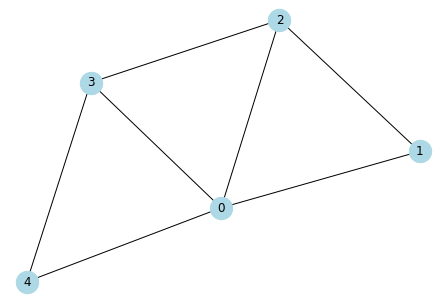

In [40]:
'''
Dynamic Graph steps:

1.) Each time step has a new graph, put them in a list.

2.) For each time step, create a new graph and put them in a Python3 list.
From 'delaunay simplices' you create a new graph. nodes are animals and links
are nearest neighbors. links should encode distances.

3.) Apply DG clustering on these graphs to get clusters over time.

4.) Compare results between DG and ST algos.
'''


# Python3 list to hold a graph for each time step-
graph_list = []


# Create a new graph for each time step, compute edges, add them to graph and
# finally, add graph to Python3 list-
for item in del_dict['delaunay_object']:
    # Create an empty graph with no nodes and no edges.
    G = nx.Graph()

    # Add path to graph-
    for path in item.simplices:
        nx.add_path(G, path)

    # Add graph of current time step to list-
    graph_list.append(G)


# Sanity check-
len(graph_list)
# 43201

# Sanity check-
len(graph_list) == len(del_dict['time'])
# True


# Bonus: Visualize graph for time step '10'-
nx.draw(graph_list[9], with_labels = True, node_size = 500, node_color = 'lightblue')
plt.show()

In [47]:
feats

,time,animal_id,x,y,distance,average_speed,average_acceleration,direction,stopped
0,1,312,49.663862,84.937627,0.000000,0.046467,-0.004028,0.000000,1
1,2,312,49.666681,84.851367,0.086306,0.042439,-0.004028,-88.128385,1
2,3,312,49.666681,84.785013,0.066354,0.038588,-0.004028,-90.000000,1
3,4,312,49.665271,84.738565,0.046469,0.035147,-0.004028,-91.738013,1
4,5,312,49.663862,84.705388,0.033207,0.034257,-0.004028,-92.432502,1
...,...,...,...,...,...,...,...,...,...
4995,996,905,86.856088,30.854640,0.613156,0.578979,0.003039,64.397082,0
4996,997,905,87.143602,31.469521,0.678781,0.590058,0.010636,64.939522,0
4997,998,905,87.448029,32.106520,0.706005,0.611454,0.015766,64.456496,0
4998,999,905,87.759503,32.761214,0.725010,0.638134,0.019306,64.556989,0


In [35]:
len(graph_list)

1000

#### Producing a voronoi diagram
Each timestep gets a voronoi object as well as the area of the voronoi - shape. Infinity, if respective animal is outmost in swarm.

Voronoi object contains the following attributes:

- `points` Coordinates of input points.

- `vertices` Coordinates of the Voronoi vertices.

- `ridge_points` Indices of the points between which each Voronoi ridge lies.

- `ridge_vertices` Indices of the Voronoi vertices forming each Voronoi ridge.

- `regions` Indices of the Voronoi vertices forming each Voronoi region. -1 indicates vertex outside the Voronoi diagram.

- `point_region` Index of the Voronoi region for each input point. If qhull option “Qc” was not specified, the list will contain -1 for points that are not associated with a Voronoi region.

- `furthest_site` True if this was a furthest site triangulation and False if not.



#### Producing a convex hull
Similar to voronoi-diagram, also the convex hull is of interest for movement-related data. Additionally, a set of attributes may be attached to the convex hull objects. Examples are:

- `points` (array of ints) Coordinates of input points

- `vertices` (array of ints ) Point indices forming the veritces of the convex hull

- `area` Area of the convex hull.

- `volume` Volume of the convex hull.

#### Producing Delaunay-triangles
Examples for attributes of interest consist of:

- `transform`	Affine transform from x to the barycentric coordinates c.
- `vertex_to_simplex`	Lookup array, from a vertex, to some simplex which it is a part of.
- `convex_hull`	Vertices of facets forming the convex hull of the point set.
- `vertex_neighbor_vertices`	Neighboring vertices of vertices.
- `points`	(ndarray of double, shape (npoints, ndim)) Coordinates of input points.
- `simplices`	(ndarray of ints, shape (nsimplex, ndim+1)) Indices of the points forming the simplices in the triangulation. For 2-D, the points are oriented counterclockwise.
- `neighbors`	(ndarray of ints, shape (nsimplex, ndim+1)) Indices of neighbor simplices for each simplex. The kth neighbor is opposite to the kth vertex. For simplices at the boundary, -1 denotes no neighbor. 

#### Plotting all spatial objects at the 3rd timestep. 

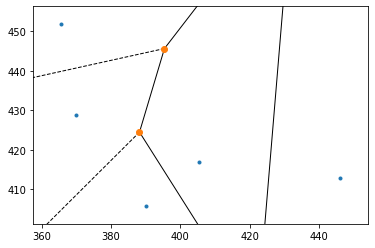

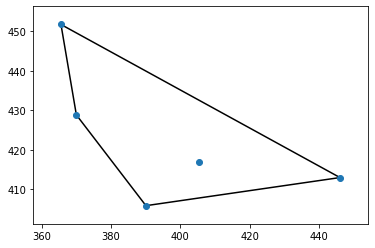

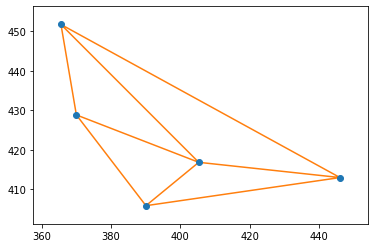

In [8]:
# Plot all scipy - spatial objects of a given timestamp
voronoi_plot_2d(spatial_obj.voronoi_object[3])
convex_hull_plot_2d(spatial_obj.convex_hull_object[3])
delaunay_plot_2d(spatial_obj.delaunay_object[3])
plt.show()